In [1]:
import sys
sys.path.append('../')

In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.data_processing import create_feature_pipeline
from src.utils import load_data, saveData


In [3]:
df = load_data('../data/raw/data.csv')
df.head()

Data loaded successfully from ../data/raw/data.csv


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [4]:
df.isna().sum().sum()

np.int64(0)

In [5]:
# ⚙️ Apply feature pipeline
pipeline = create_feature_pipeline()
transformed = pipeline.fit_transform(df)

In [6]:
# 🏷️ Build full column list
cat_cols = pipeline.named_steps["preprocessor"].named_transformers_["cat"]\
    .named_steps["onehot"].get_feature_names_out(['ProductCategory', 'ChannelId', 'PricingStrategy'])

all_cols = ['Amount', 'Value', 'Frequency', 'AvgAmount', 'AmountStdDev', 'Recency'] + list(cat_cols)

# 🧾 Create transformed DataFrame
transformed_df = pd.DataFrame(transformed, columns=all_cols)
transformed_df.head()

# 🔁 Integrate is_high_risk directly and cleanly from rfm_features
rfm_df = pipeline.named_steps["rfm_features"].transform(df)
transformed_df["is_high_risk"] = rfm_df["is_high_risk"].values

In [7]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Amount                              95662 non-null  float64
 1   Value                               95662 non-null  float64
 2   Frequency                           95662 non-null  float64
 3   AvgAmount                           95662 non-null  float64
 4   AmountStdDev                        95662 non-null  float64
 5   Recency                             95662 non-null  float64
 6   ProductCategory_airtime             95662 non-null  float64
 7   ProductCategory_data_bundles        95662 non-null  float64
 8   ProductCategory_financial_services  95662 non-null  float64
 9   ProductCategory_movies              95662 non-null  float64
 10  ProductCategory_other               95662 non-null  float64
 11  ProductCategory_ticket              95662

In [8]:
# 📈 Summary statistics
transformed_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Amount,95662.0,-9.507377e-18,1.000005,-2.381578,-0.939052,0.643134,0.793313,1.985477
Value,95662.0,4.325857e-16,1.000005,-2.739134,-0.631710,-0.031260,0.718461,4.255216
Frequency,95662.0,5.704426e-16,1.000005,-2.395688,-0.676276,-0.034240,0.621932,2.280194
AvgAmount,95662.0,-2.947287e-16,1.000005,-4.989505,0.041973,0.189404,0.335826,2.251597
AmountStdDev,95662.0,-3.684109e-16,1.000005,-5.996952,-0.381968,0.050070,0.446160,4.467522
Recency,95662.0,-2.091623e-16,1.000005,-1.182989,-1.182989,-0.142576,0.978531,1.996678
ProductCategory_airtime,95662.0,4.706885e-01,0.499143,0.000000,0.000000,0.000000,1.000000,1.000000
ProductCategory_data_bundles,95662.0,1.686145e-02,0.128753,0.000000,0.000000,0.000000,0.000000,1.000000
ProductCategory_financial_services,95662.0,4.746399e-01,0.499359,0.000000,0.000000,0.000000,1.000000,1.000000
ProductCategory_movies,95662.0,1.829358e-03,0.042732,0.000000,0.000000,0.000000,0.000000,1.000000


c:\Users\user\Documents\Datasience\credict-risk-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


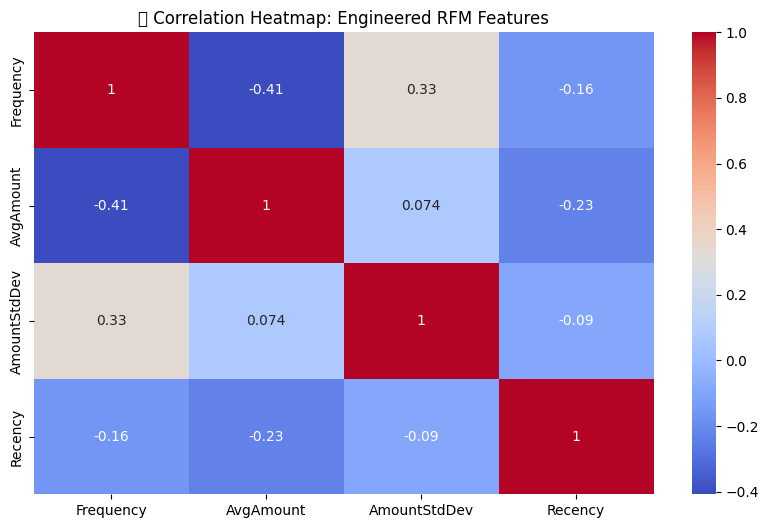

In [9]:
# 🔍 Correlation between numerical features
plt.figure(figsize=(10,6))
sns.heatmap(transformed_df[['Frequency', 'AvgAmount', 'AmountStdDev', 'Recency']].corr(), annot=True, cmap='coolwarm')
plt.title("📊 Correlation Heatmap: Engineered RFM Features")
plt.show()

c:\Users\user\Documents\Datasience\credict-risk-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


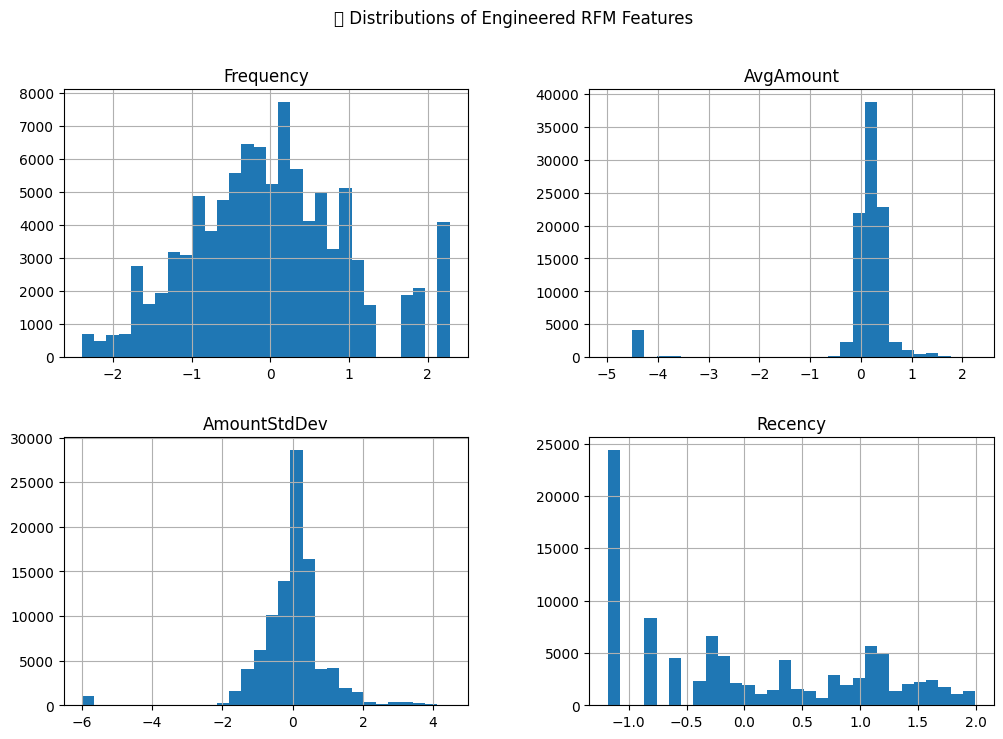

In [10]:
# 📉 Histograms of important numerical features
transformed_df[['Frequency', 'AvgAmount', 'AmountStdDev', 'Recency']].hist(bins=30, figsize=(12, 8))
plt.suptitle("📊 Distributions of Engineered RFM Features")
plt.show()

In [11]:
# 💾 Save for modeling
saveData( transformed_df, "../data/processed/processed_data.csv")

Data saved successfully to ../data/processed/processed_data.csv


## ✅ Summary

- Successfully engineered 4 RFM features: `Frequency`, `AvgAmount`, `AmountStdDev`, and `Recency`
- Applied log scaling and standardization to skewed numerical columns: `Amount`, `Value`, `Frequency`, `AvgAmount`, `AmountStdDev`
- Extracted datetime features: `Hour`, `DayOfWeek`, `Month`
- Encoded categorical features (`ProductCategory`, `ChannelId`, `PricingStrategy`) using `OneHotEncoder` with `handle_unknown='ignore'`
- Handled missing values via imputation (`mean` for numeric, `constant=0` for log-scaled)
- Clustered customers into 3 segments using KMeans and assigned a proxy binary target variable `is_high_risk`
- Final model-ready dataset includes all transformed features and the target column `is_high_risk`
- Pipeline is fully automated and reproducible via `sklearn.pipeline.Pipeline`
- Output is ready for training: `X = transformed_df.drop(columns=["is_high_risk"])`, `y = transformed_df["is_high_risk"]`
